In [28]:
import pandas

import pygsheets
import numpy
import re

# import data directly from google sheets

In [2]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
#spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')
spreadsheet = gc.open_by_key('1VnhD3K8bUn-CwTGUt-XkF42jcWAaZwasKIryEO7V1j4') # May 2024 release

gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A3')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A3')

pipes_df_orig = oil_pipes.copy() #pandas.concat([gas_pipes, oil_pipes], ignore_index=True)

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

In [3]:
fuel_type = 'Oil'

In [4]:
gas_fuel_options = ['Gas']
ngl_fuel_options = ['NGL', 
                    'NGL, oil products', 
                    'Oil, NGL', 
                    'Oil, NGL, naphtha']
oil_fuel_options = ['Oil', 
                    'Oil, NGL', 
                    'Oil, NGL, naphtha']

In [5]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_28351/2705967703.py:49: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T

In [19]:
status_list = ['proposed', 
               'construction', 
               'shelved', 
               'cancelled', 
               'operating', 
               'idle', 
               'mothballed', 
               'retired']
country_list = sorted(set(region_df_orig['Country'].tolist()))
region_list = sorted(set(region_df_orig['Region'].tolist()))
if '--' in region_list:
    region_list.remove('--')
subregion_list = sorted(set(region_df_orig['SubRegion'].tolist()))
if '--' in subregion_list:
    subregion_list.remove('--')

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [20]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']

missing_wiki_projectids = pipes_df_orig.loc[pipes_df_orig.Wiki==''].ProjectID.tolist()
pipes_df_orig = pipes_df_orig[pipes_df_orig['RouteAccuracy']!='']

country_ratios_df.replace('--', numpy.nan, inplace=True)
country_ratios_df = country_ratios_df.loc[~country_ratios_df.ProjectID.isin(missing_wiki_projectids)]

# km by country, km by region calculations

In [21]:
dict_subregion_region = pandas.Series(region_df_orig.Region.values, index=region_df_orig.SubRegion).to_dict()
#dict_subregion_region

In [22]:
region_df_orig_cleaned = region_df_orig.loc[(region_df_orig.Region!='--')&
                                            (region_df_orig.SubRegion!='--')]
multiindex_region_subregion = region_df_orig_cleaned.groupby(['Region','SubRegion'])['Country'].count().index
multiindex_region_subregion_country = region_df_orig_cleaned.groupby(['Region','SubRegion','Country'])['Country'].count().index

In [23]:
country_ratios_fuel_df = country_ratios_df[country_ratios_df.Fuel.isin(oil_fuel_options)]

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_subregion_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    km_by_country_df[status] = country_ratios_fuel_df_status.groupby('Country')['LengthMergedKmByCountry'].sum()
    km_by_subregion_df[status] = country_ratios_fuel_df_status.groupby(['Region','SubRegion'])['LengthMergedKmByCountry'].sum()
    km_by_region_df[status] = country_ratios_fuel_df_status.groupby('Region')['LengthMergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_subregion_df = km_by_subregion_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)
km_by_region_df = km_by_region_df.fillna(0)

#km_by_region_df.sort_index(level='Region', inplace=True)
#km_by_region_df = km_by_region_df.loc[~(km_by_region_df==0).all(axis=1)]

# total
# km_by_region_df.loc['Total',:] = km_by_region_df.sum(axis=0).values
# km_by_country_df.loc['Total',:] = km_by_country_df.sum(axis=0).values

km_by_subregion_df['proposed+construction'] = km_by_subregion_df[['proposed','construction']].sum(axis=1)
km_by_subregion_df = km_by_subregion_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]

km_by_country_df['proposed+construction'] = km_by_country_df[['proposed','construction']].sum(axis=1)
km_by_country_df.sort_values('proposed+construction', ascending=False, inplace=True)
km_by_country_df = km_by_country_df.loc[~(km_by_country_df==0).all(axis=1)]
km_by_country_df.loc[:,'Region'] = region_df_orig.set_index('Country').loc[km_by_country_df.index.tolist()].Region
km_by_country_df.loc[:,'Subregion'] = region_df_orig.set_index('Country').loc[km_by_country_df.index.tolist()].SubRegion
km_by_country_df = km_by_country_df[['Region','Subregion','proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
km_by_country_df = km_by_country_df.loc[(km_by_country_df.Region!='--')&
                                        (km_by_country_df.Subregion!='--')]

km_by_region_df['proposed+construction'] = km_by_region_df[['proposed','construction']].sum(axis=1)
km_by_region_df = km_by_region_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]

km_by_subregion_df.index.set_names(['Region','Subregion'], inplace=True)
km_by_subregion_df.loc['Total',:] = km_by_subregion_df.sum(axis=0).values
km_by_subregion_df.replace(0,'', inplace=False)

===country-level calculations===
proposed
construction
shelved
cancelled
operating
idle
mothballed
retired


proposed construction  \
Region   Subregion                                                
Africa   Northern Africa                      68.5        100.0   
         Sub-Saharan Africa                6482.26       1950.0   
Americas Latin America and the Caribbean     873.0        525.0   
         Northern America                  1255.34       214.38   
Asia     Central Asia                                             
         Eastern Asia                      4467.67       476.28   
         South-eastern Asia                 228.02                
         Southern Asia                       69.47       6184.0   
         Western Asia                      6898.35        175.0   
Europe   Eastern Europe                    1510.34      1237.84   
         Northern Europe                                          
         Southern Europe                    665.07                
         Western Europe                     149.26                
Oceania  Australia and New Zealand                                
         Melanesia                                                
         Micronesia                                               
         Polynesia                                                
Total                                     22667.28      10862.5   

                                         proposed+construction  shelved  \
Region   Subregion                                                        
Africa   Northern Africa                                 168.5    488.0   
         Sub-Saharan Africa                            8432.26   498.13   
Americas Latin America and the Caribbean                1398.0            
         Northern America                              1469.72  6481.75   
Asia     Central Asia                                                     
         Eastern Asia                                  4943.95            
         South-eastern Asia                             228.02            
         Southern Asia                                 6253.47            
         Western Asia                                  7073.35  1544.61   
Europe   Eastern Europe                                2748.18            
         Northern Europe                                                  
         Southern Europe                                665.07    600.0   
         Western Europe                                 149.26            
Oceania  Australia and New Zealand                                        
         Melanesia                                                        
         Micronesia                                                       
         Polynesia                                                        
Total                                                 33529.78  9612.49   

                                         cancelled  operating     idle  \
Region   Subregion                                                       
Africa   Northern Africa                    620.04    16395.8            
         Sub-Saharan Africa                 2100.0    7457.94            
Americas Latin America and the Caribbean   3937.83   26755.13            
         Northern America                 34111.89  111353.42            
Asia     Central Asia                      2048.97    9207.62            
         Eastern Asia                      7144.88   28999.58    46.35   
         South-eastern Asia                  306.0    1754.52            
         Southern Asia                     6780.04   24864.24            
         Western Asia                      2108.88    21890.4    837.0   
Europe   Eastern Europe                     4893.7   55185.79   2376.0   
         Northern Europe                              5670.85            
         Southern Europe                   1340.66    2369.91    123.0   
         Western Europe                     634.25   10850.26   271.69   
Oceania  Australia and New Zealand                     1850.3            
         Melanes

In [24]:
#km_by_country_df.to_excel('km-by-country-region-subregion.xlsx')
km_by_country_df

,Region,Subregion,proposed,construction,proposed+construction,shelved,cancelled,operating,idle,mothballed,retired
China,Asia,Eastern Asia,3880.37,476.28,4356.65,0.00,7144.88,28951.54,46.35,0.00,7601.15
Iraq,Asia,Western Asia,3755.66,75.00,3830.66,0.00,898.80,5241.73,0.00,935.15,0.00
Iran,Asia,Southern Asia,57.00,2920.00,2977.00,0.00,1536.40,14474.28,0.00,0.00,0.00
India,Asia,Southern Asia,0.00,2824.00,2824.00,0.00,1338.00,9254.17,0.00,0.00,0.00
Syria,Asia,Western Asia,2140.41,0.00,2140.41,0.00,0.00,169.51,0.00,854.17,217.11
...,...,...,...,...,...,...,...,...,...,...,...
Ethiopia,Africa,Sub-Saharan Africa,0.00,0.00,0.00,498.13,0.00,0.00,0.00,0.00,0.00
France,Europe,Western Europe,0.00,0.00,0.00,0.00,0.00,4696.81,257.61,0.00,0.00
Gabon,Africa,Sub-Saharan Africa,0.00,0.00,0.00,0.00,0.00,475.00,0.00,0.00,0.00
Georgia,Asia,Western Asia,0.00,0.00,0.00,0.00,0.00,247.54,386.72,0.00,0.00


# save km by country for dashboard

In [25]:
missing_countries = list(set(region_df_orig.Country.tolist())-set(km_by_country_df.index.tolist()))
# add empty missing rows so geometries will still be plotted in Flourish
for cntry in missing_countries:
    km_by_country_df.loc[cntry] = 0

# add 3 letter code for Flourish map
km_by_country_df['CountryISO3166-1alpha-3'] = region_df_orig.set_index('Country').loc[km_by_country_df.index,'CountryISO3166-1alpha-3']
km_by_country_df['Region'] = region_df_orig.set_index('Country').loc[km_by_country_df.index,'Region']
km_by_country_df['Subregion'] = region_df_orig.set_index('Country').loc[km_by_country_df.index,'SubRegion']
km_by_country_df.sort_values('construction', ascending=False).drop('Antarctica').replace(0,'').to_excel('km-by-country-region-subregion-sorted-by-construction.xlsx')
#km_by_country_df.sort_values('construction', ascending=False).drop('Antarctica').to_excel('km-by-country-region-subregion-sorted-by-construction.xlsx')

In [26]:
km_by_country_df

,Region,Subregion,proposed,construction,proposed+construction,shelved,cancelled,operating,idle,mothballed,retired,CountryISO3166-1alpha-3
China,Asia,Eastern Asia,3880.37,476.28,4356.65,0.0,7144.88,28951.54,46.35,0.00,7601.15,CHN
Iraq,Asia,Western Asia,3755.66,75.00,3830.66,0.0,898.80,5241.73,0.00,935.15,0.00,IRQ
Iran,Asia,Southern Asia,57.00,2920.00,2977.00,0.0,1536.40,14474.28,0.00,0.00,0.00,IRN
India,Asia,Southern Asia,0.00,2824.00,2824.00,0.0,1338.00,9254.17,0.00,0.00,0.00,IND
Syria,Asia,Western Asia,2140.41,0.00,2140.41,0.0,0.00,169.51,0.00,854.17,217.11,SYR
...,...,...,...,...,...,...,...,...,...,...,...,...
Belize,Americas,Latin America and the Caribbean,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,BLZ
Tuvalu,Oceania,Polynesia,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,TUV
Guernsey,Europe,Northern Europe,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,GGY
Liechtenstein,Europe,Western Europe,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,LIE


# parent analysis

In [29]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in country_ratios_df.loc[(country_ratios_df.Fuel.isin(oil_fuel_options))&
                                (country_ratios_df.Status.isin(['proposed','construction']))].iterrows():
    parent_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].Parent.values[0]
    #print(parent_string)
    if parent_string == '--':
        parent_string = 'Unknown [unknown %]'
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have an "Owner [%]" syntax, so [unknown %] is included
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]
    #print(percent_list)

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    # for when database isn't completely filled in for owners:
    for p_idx,parent in enumerate(parent_list):
        if parent not in parents_df.index.to_list():
            parents_df.loc[parent,'ParentHQCountry']='Unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'ParentHQCountry':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'PipelineCountry':row.Country,
                                                                         'Status':row.Status,
                                                                         'LengthMergedKmByCountry':row.LengthMergedKmByCountry,
                                                                         'LengthMergedKmByPipeline':row.LengthMergedKmByPipeline,
                                                                         'CapacityBOEd':row.CapacityBOEd}])])

owner_parent_calculations_df['KmOwnershipByCountry'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.LengthMergedKmByCountry

## print out leading parent companies

In [30]:
parent_country_km_df = \
owner_parent_calculations_df.loc[#(owner_parent_calculations_df.PipelineCountry.isin(region_df_touse.Country.tolist()))&
                                 (owner_parent_calculations_df.Status.isin(['proposed','construction']))]

parent_country_km_df_table = pandas.DataFrame(index=parent_country_km_df.Parent.unique().tolist(),
                                             columns=['Pipeline Country Locations','Owner Headquarters Country',
                                                      'proposed','construction','In Development (proposed + construction)','ProjectIDs'])

parent_country_km_df_table['proposed'] = parent_country_km_df.loc[parent_country_km_df.Status=='proposed'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]
parent_country_km_df_table['construction'] = parent_country_km_df.loc[parent_country_km_df.Status=='construction'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]

parent_country_km_df_table = parent_country_km_df_table.loc[parent_country_km_df_table.index!='']

In [31]:
# top n parents
n=20

In [44]:
country_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).PipelineCountry.agg(lambda x: ', '.join(x.unique())))
projectid_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).ProjectID.agg(lambda x: ', '.join(x.unique())))
parent_country_km_df_table['Pipeline Country Locations'] = country_agg_df.PipelineCountry
parent_country_km_df_table['Number of Projects'] = owner_parent_calculations_df.groupby(['Parent']).ProjectID.count()
parent_country_km_df_table['ProjectIDs'] = projectid_agg_df.ProjectID
parent_country_km_df_table['Owner Headquarters Country'] = parent_country_km_df.drop_duplicates('Parent').set_index('Parent').ParentHQCountry
parent_country_km_df_table['In Development (proposed + construction)'] = parent_country_km_df_table[['proposed','construction']].sum(axis=1, min_count=0)
#parent_country_km_df_table.loc[~parent_country_km_df_table.index.isin(['Not in database','Unknown'])].replace(numpy.nan, 0).sort_values('In Development (proposed + construction)', ascending=False)[:n].to_excel('parent-country-km-table.xlsx')
parent_country_km_df_table.loc[~parent_country_km_df_table.index.isin(['Not in database','Unknown'])].replace(numpy.nan, 0).sort_values('In Development (proposed + construction)', ascending=False)[:n]


,Pipeline Country Locations,Owner Headquarters Country,proposed,construction,In Development (proposed + construction),ProjectIDs,Number of Projects
unknown,"China, Angola, Zambia, Syria, Iraq, Iran, Unit...",unknown,4064.2100,525.98,4590.1900,"P5176, P5177, P5178, P5239, P5277, P5278, P527...",16
Iraq Ministry of Oil,"Jordan, Iraq, Syria",Iraq,4053.2700,75.00,4128.2700,"P0544, P3874, P3875, P5240, P5284, P5285, P5291",11
Iran Ministry of Petroleum,Iran,Iran,57.0000,2463.00,2520.0000,"P2221, P2222, P2226, P2229, P3848, P5287, P533...",19
China National Petroleum Corporation,"Benin, Nigeria, Niger",China,0.0000,1950.00,1950.0000,P1328,3
"National Petroleum and Natural Gas Pipeline Network Group Co., Ltd.",China,China,1724.7886,0.00,1724.7886,"P2037, P3750, P3770, P6095, P6096, P6270, P6298",7
Numaligarh Refinery Limited,India,India,0.0000,1630.00,1630.0000,P3843,1
TotalEnergies,"South Sudan, Kenya, Tanzania, Uganda",France,1377.3450,0.00,1377.3450,"P0531, P0538, P0541",5
Indian Oil Corporation,India,India,0.0000,1194.00,1194.0000,P3889,1
Government of Zambia,"Zambia, Tanzania",Zambia,1140.5700,0.00,1140.5700,P2481,2
"Hongrun Petrochemical Co., Ltd.","Japan, China, South Korea",China,986.6700,0.00,986.6700,P6185,3


# fluvial owner plot for dashboard

In [45]:
top_n_parents_df = parent_country_km_df_table.drop('unknown').sort_values('In Development (proposed + construction)', ascending=False)[:n]

In [46]:
top_n_parents_df['In Development (proposed + construction)'].sum()/parent_country_km_df_table['In Development (proposed + construction)'].sum()

0.7062533525385829

In [47]:
top_n_parents_list = top_n_parents_df.index.tolist()

In [48]:
owner_parent_calculations_df.loc[(owner_parent_calculations_df.Parent.isin(top_n_parents_list))&
                                (owner_parent_calculations_df.Status.isin(['proposed','construction']))][['Parent',
                                                                                                          'ParentHQCountry',
                                                                                                          'PipelineCountry',
                                                                                                          'Status',
                                                                                                          'LengthMergedKmByCountry']].replace({'proposed':'Proposed','construction':'Construction'}).to_excel(f'parent-fluvial-diagram-top-{n}.xlsx')

# cost estimates (pipeline cost per km)

## pick out high and low quantiles

In [49]:
temp_df = pipes_df_orig.loc[(~pipes_df_orig.CostUSDPerKm.isnull())&
                            (pipes_df_orig.Fuel.isin(oil_fuel_options))]
qlo_val = 0.025
qhi_val = 0.975

q_lo=temp_df['CostUSDPerKm'].quantile(qlo_val)
q_hi=temp_df['CostUSDPerKm'].quantile(qhi_val)
print(temp_df['CostUSDPerKm'].quantile(qlo_val))
print(temp_df['CostUSDPerKm'].quantile(qhi_val))

temp_df = temp_df.loc[temp_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]

69074.64035825
16101351.798000017


In [50]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.loc[(country_ratios_df.Fuel.isin(oil_fuel_options)) & 
                                                               (country_ratios_df['CostUSDPerKm'].notna()) & 
                                                               (country_ratios_df['LengthKnownKmByCountry'].notna()) #&
                                                               #(country_ratios_df['LengthKnownKm']!=0) &
                                                               #(country_ratios_df['CostUSDPerKm']<10e6)
                                                              ]

country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df.loc[
    country_ratios_with_length_and_cost_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

In [51]:
country_ratios_df.loc[(country_ratios_df.Fuel.isin(oil_fuel_options)) & 
                    (country_ratios_df['CostUSDPerKm'].notna()) & 
                    (country_ratios_df['LengthKnownKmByCountry'].notna())].shape

(174, 36)

In [52]:
country_ratios_df.loc[(country_ratios_df.Fuel.isin(oil_fuel_options))].shape

(1418, 36)

### global mean value

In [53]:
global_mean = country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

2957516.0809756103

### calculate regional costs

In [54]:
region_list

['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

In [55]:
pipes_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for region in region_list:
    country_ratios_region_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['Region']==region,:]
    pipes_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_costs_region_df.loc[region,'DataPoints'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_28351/466907183.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3722739.40125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pipes_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()


In [56]:
pipes_costs_subregion_df = pandas.DataFrame(0, index=subregion_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for subregion in subregion_list:
    country_ratios_subregion_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['SubRegion']==subregion,:]
    n_datapoints = list(set(country_ratios_subregion_df['ProjectID'])).__len__()
    if n_datapoints < 3:
        pipes_costs_subregion_df.loc[subregion,'DataPoints'] = list(set(country_ratios_subregion_df['ProjectID'])).__len__()
        pipes_costs_subregion_df.loc[subregion,'CostUSDPerKm'] = pipes_costs_region_df.loc[dict_subregion_region[subregion],'CostUSDPerKm']
    else:
        pipes_costs_subregion_df.loc[subregion,'DataPoints'] = list(set(country_ratios_subregion_df['ProjectID'])).__len__()
        pipes_costs_subregion_df.loc[subregion,'CostUSDPerKm'] = country_ratios_subregion_df['CostUSDPerKm'].mean()

pipes_costs_subregion_df.sort_values('CostUSDPerKm', ascending=False)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_28351/2437797586.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1213941.655' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pipes_costs_subregion_df.loc[subregion,'CostUSDPerKm'] = country_ratios_subregion_df['CostUSDPerKm'].mean()


,CostUSDPerKm,DataPoints
Sub-Saharan Africa,4.137336e+06,5
Eastern Asia,3.814921e+06,33
Eastern Europe,3.495943e+06,13
Western Asia,3.325484e+06,13
Central Asia,3.137221e+06,2
Northern America,3.126386e+06,32
Northern Africa,2.810626e+06,5
Latin America and the Caribbean,2.562211e+06,11
Northern Europe,2.536886e+06,0
Western Europe,2.536886e+06,1


In [57]:
pipes_costs_region_df

,CostUSDPerKm,DataPoints
Africa,3.722739e+06,10
Americas,2.970338e+06,43
Asia,3.137221e+06,60
Europe,2.536886e+06,13
Oceania,1.213942e+06,6


In [58]:
country_ratios_region_df['CostUSDPerKm'].mean()

1213941.655

In [59]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_costs_region_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Africa,3.723,10
Asia,3.137,60
Americas,2.970,43
Europe,2.537,13
Oceania,1.214,6


In [60]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_costs_subregion_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Sub-Saharan Africa,4.137,5
Eastern Asia,3.815,33
Eastern Europe,3.496,13
Western Asia,3.325,13
Central Asia,3.137,2
Northern America,3.126,32
Northern Africa,2.811,5
Latin America and the Caribbean,2.562,11
Northern Europe,2.537,0
Western Europe,2.537,1


# tables etc.

## table for stranded asset calculations

## country-level capex estimates

In [61]:
country_ratios_df_specific_fuel = country_ratios_df.loc[country_ratios_df.Fuel.isin(oil_fuel_options)]
country_ratios_df_specific_fuel.reset_index(drop=True, inplace=True)
country_ratios_df_specific_fuel.loc[:,'CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_df_specific_fuel.iterrows():
    # calculate cost
    cntry = row.Country
    #region = row.Region
    subregion = row.SubRegion
    km_by_cntry = row.LengthMergedKmByCountry
    #country_ratios_df.loc[idx,'CostUSDEstimate'] = pipes_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry
    country_ratios_df_specific_fuel.loc[idx,'CostUSDEstimate'] = pipes_costs_subregion_df.loc[subregion, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_df_specific_fuel.loc[(~country_ratios_df_specific_fuel.LengthKnownKmByCountry.isna())&
                    (~country_ratios_df_specific_fuel.CostUSDPerKm.isna()),'CostUSDEstimate'] = \
country_ratios_df_specific_fuel.loc[(~country_ratios_df_specific_fuel.LengthKnownKmByCountry.isna())&
                    (~country_ratios_df_specific_fuel.CostUSDPerKm.isna()), 'LengthMergedKmByCountry'] * \
country_ratios_df_specific_fuel.loc[(~country_ratios_df_specific_fuel.LengthKnownKmByCountry.isna())&
                    (~country_ratios_df_specific_fuel.CostUSDPerKm.isna()), 'CostUSDPerKm']

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_28351/3748187952.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_specific_fuel.loc[:,'CostUSDEstimate'] = numpy.nan


In [62]:
country_ratios_df_specific_fuel.SubRegion.unique()

array(['Northern America', 'Latin America and the Caribbean',
       'Northern Africa', 'Sub-Saharan Africa', 'Western Asia',
       'Southern Asia', 'Eastern Europe', 'Central Asia', 'Eastern Asia',
       'Southern Europe', 'Western Europe', 'Northern Europe',
       'South-eastern Asia', 'Melanesia', 'Australia and New Zealand'],
      dtype=object)

In [63]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)
capex_by_subregion_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_df_specific_fuel_status = country_ratios_df_specific_fuel.loc[country_ratios_df_specific_fuel.Status==status]
    country_ratios_df_specific_fuel_status = country_ratios_df_specific_fuel_status.loc[~country_ratios_df_specific_fuel_status.SubRegion.isnull()]
    capex_by_country_df[status] = country_ratios_df_specific_fuel_status.groupby('Country')['CostUSDEstimate'].sum()/1e9
    capex_by_region_df[status] = country_ratios_df_specific_fuel_status.groupby('Region')['CostUSDEstimate'].sum()/1e9
    capex_by_subregion_df[status] = country_ratios_df_specific_fuel_status.groupby(['Region','SubRegion'])['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)
capex_by_subregion_df = capex_by_subregion_df.fillna(0)

capex_by_region_df['proposed+construction'] = capex_by_region_df[['proposed','construction']].sum(axis=1)
capex_by_region_df = capex_by_region_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
# capex_by_region_df.loc['Total',:] = capex_by_region_df.sum(axis=0).values

capex_by_country_df['proposed+construction'] = capex_by_country_df[['proposed','construction']].sum(axis=1)
capex_by_country_df = capex_by_country_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
#capex_by_country_df.sort_values('construction', ascending=False, inplace=True)
# capex_by_country_df.loc['Total',:] = capex_by_country_df.sum(axis=0).values

capex_by_subregion_df['proposed+construction'] = capex_by_subregion_df[['proposed','construction']].sum(axis=1)
capex_by_subregion_df = capex_by_subregion_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
# capex_by_subregion_df.loc['Total',:] = capex_by_subregion_df.sum(axis=0).values

===country-level calculations===
proposed
construction
shelved
cancelled
operating
idle
mothballed
retired


# save capex by country for dashboard

In [64]:
missing_countries = list(set(region_df_orig.Country.tolist())-set(capex_by_country_df.index.tolist()))
# add empty missing rows so geometries will still be plotted in Flourish
for cntry in missing_countries:
    capex_by_country_df.loc[cntry] = 0

# add 3 letter code for Flourish map
capex_by_country_df['CountryISO3166-1alpha-3'] = region_df_orig.set_index('Country').loc[capex_by_country_df.index,'CountryISO3166-1alpha-3']
# add regions, subregions
capex_by_country_df['Region'] = region_df_orig.set_index('Country').loc[capex_by_country_df.index,'Region']
capex_by_country_df['Subregion'] = region_df_orig.set_index('Country').loc[capex_by_country_df.index,'SubRegion']

capex_by_country_df.sort_values('proposed+construction', ascending=False).to_excel('capex-by-country-sorted-by-in-dev.xlsx')

In [65]:
capex_by_country_df

,proposed,construction,proposed+construction,shelved,cancelled,operating,idle,mothballed,retired,CountryISO3166-1alpha-3,Region,Subregion
Afghanistan,0.000,0.000,0.000,0.000,1.868,0.000,0.000,0.000,0.000,AFG,Asia,Southern Asia
Albania,0.160,0.000,0.160,0.199,0.000,0.000,0.000,0.000,0.000,ALB,Europe,Southern Europe
Algeria,0.000,0.000,0.000,0.000,0.000,13.896,0.000,0.000,0.000,DZA,Africa,Northern Africa
American Samoa,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ASM,Oceania,Polynesia
Andorra,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AND,Europe,Southern Europe
...,...,...,...,...,...,...,...,...,...,...,...,...
Western Sahara,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ESH,Africa,Northern Africa
Yemen,0.000,0.000,0.000,0.000,0.000,2.626,0.000,0.000,0.000,YEM,Asia,Western Asia
Zambia,6.354,0.000,6.354,0.000,0.000,0.004,0.000,0.000,0.000,ZMB,Africa,Sub-Saharan Africa
Zimbabwe,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ZWE,Africa,Sub-Saharan Africa


In [66]:
capex_by_region_df.replace(0,'')

,proposed,construction,proposed+construction,shelved,cancelled,operating,idle,mothballed,retired
Africa,24.517,7.281,31.798,3.433,10.431,69.335,,,
Americas,8.393,1.801,10.194,20.264,115.386,431.820,,,20.177
Asia,62.019,12.441,74.460,5.137,52.354,239.700,2.960,10.106,34.936
Europe,11.232,3.987,15.219,0.596,19.108,231.488,6.685,6.940,4.901
Oceania,,,,,,2.338,,,0.227


In [67]:
capex_by_subregion_df.index = capex_by_subregion_df.index.set_names(['Region','Subregion'])
capex_by_subregion_df.replace(0,'')

proposed construction  \
Region   Subregion                                               
Africa   Northern Africa                    0.193        0.281   
         Sub-Saharan Africa                24.324        7.000   
Americas Latin America and the Caribbean    4.225        1.200   
         Northern America                   4.168        0.601   
Asia     Central Asia                                            
         Eastern Asia                      12.357        1.260   
         South-eastern Asia                 0.255                
         Southern Asia                      0.122       10.728   
         Western Asia                      49.286        0.453   
Europe   Eastern Europe                    10.208        3.987   
         Northern Europe                                         
         Southern Europe                    0.646                
         Western Europe                     0.379                
Oceania  Australia and New Zealand                               
         Melanesia                                               
         Micronesia                                              
         Polynesia                                               

                                         proposed+construction shelved  \
Region   Subregion                                                       
Africa   Northern Africa                                 0.474   1.372   
         Sub-Saharan Africa                             31.324   2.061   
Americas Latin America and the Caribbean                 5.425           
         Northern America                                4.769  20.264   
Asia     Central Asia                                                    
         Eastern Asia                                   13.616           
         South-eastern Asia                              0.255           
         Southern Asia                                  10.850           
         Western Asia                                   49.739   5.137   
Europe   Eastern Europe                                 14.195           
         Northern Europe                                                 
         Southern Europe                                 0.646   0.596   
         Western Europe                                  0.379           
Oceania  Australia and New Zealand                                       
         Melanesia                                                       
         Micronesia                                                      
         Polynesia                                                       

                                         cancelled operating  idle mothballed  \
Region   Subregion                                                              
Africa   Northern Africa                     1.743    45.073                    
         Sub-Saharan Africa                  8.688    24.261                    
Americas Latin America and the Caribbean     9.103    66.733                    
         Northern America                  106.282   365.086                    
Asia     Central Asia                        6.428    28.009            2.402   
         Eastern Asia                       27.257   104.476 0.177              
         South-eastern Asia                  0.380     1.866                    
         Southern Asia                      11.276    40.518                    
         Western Asia                        7.013    64.831 2.783      7.705   
Europe   Eastern Europe                     15.832   185.067 5.874      5.668   
         Northern Europe                              16.708            1.272   
         Southern Europe                     1.780     2.188 0.122              
         Western Europe                      1.496    27.526 0.689              
Oceania  Australia and New Zealand                     2.017                    
         Melanesia                                     0.322                    
  

## sort into categories for capex map

<Axes: ylabel='Frequency'>

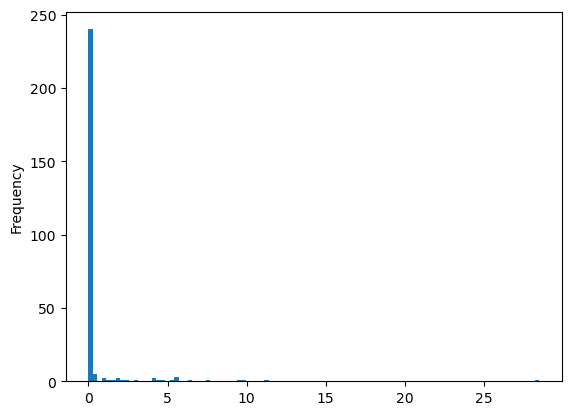

In [68]:
capex_by_country_df['proposed+construction'].plot.hist(bins=100)

In [69]:
capex_by_country_df['proposed+construction'].describe()

count   268.000
mean      0.491
std       2.284
min       0.000
25%       0.000
50%       0.000
75%       0.000
max      28.503
Name: proposed+construction, dtype: float64

In [70]:
#bins = [0,0.05,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5,10,15,20,25,30]
bins = [0,1,5,10,20,30]
# create names for these bins, add an empty one up front
category_names = ['']+[f'US${str(bins[i])}–{str(bins[i+1])} billion' for i in range(bins.__len__()-1)]

# sort values into bins
bin_indices = numpy.digitize(capex_by_country_df['proposed+construction'].values, bins) # starts at 1

capex_by_country_df['proposed+construction bins'] = numpy.array(category_names)[bin_indices]

capex_by_country_df.sort_values('proposed+construction', ascending=False).to_excel('capex-by-country-sorted-by-in-dev-binned.xlsx')

# how much per year

In [71]:
pipes_started = pipes_df_orig.loc[(pipes_df_orig.Status=='operating') & 
                                    (pipes_df_orig.Fuel.isin(oil_fuel_options))]
pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()


pipes_proposed = pipes_df_orig.loc[(pipes_df_orig.Status=='proposed') & 
                                    (pipes_df_orig.Fuel.isin(oil_fuel_options))]
pipes_proposed_sum = pipes_proposed.groupby('ProposalYear')['LengthMergedKm'].sum()


pipes_construction = pipes_df_orig.loc[(pipes_df_orig.Status=='construction') & 
                                    (pipes_df_orig.Fuel.isin(oil_fuel_options))]
pipes_construction_sum = pipes_construction.groupby('ConstructionYear')['LengthMergedKm'].sum()

In [72]:
if fuel_type == 'Gas':
    km_by_start_year = pandas.DataFrame(index=list(range(1980,2025)), columns=['Gas pipeline km'])
    km_by_start_year.index.name = 'Start year'
    km_by_start_year['Gas pipeline km'] = pipes_started_sum
    km_by_start_year.replace(numpy.nan,0,inplace=True)

if fuel_type == 'Oil':
    km_by_start_year = pandas.DataFrame(index=list(range(1980,2025)))
    km_by_start_year.index.name = 'Start year'
    km_by_start_year['Oil pipeline km operating'] = pipes_started_sum
    km_by_start_year['Oil pipeline km construction'] = pipes_construction_sum
    km_by_start_year['Oil pipeline km proposed'] = pipes_proposed_sum
    km_by_start_year.replace(numpy.nan,0,inplace=True)

if fuel_type == 'NGL':
    km_by_start_year = pandas.DataFrame(index=list(range(1980,2025)), columns=['NGL pipeline km'])
    km_by_start_year.index.name = 'Start year'
    km_by_start_year['NGL pipeline km'] = pipes_started_sum
    km_by_start_year.replace(numpy.nan,0,inplace=True)

km_by_start_year.loc['Total',:] = km_by_start_year.sum(axis=0)

km_by_start_year.to_excel('km-by-start-year.xlsx')
#km_by_start_year

# numbers for dashboard

In [ ]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['construction']/km_by_country_total['proposed+construction']

In [ ]:
km_by_country_total.construction.sum()

In [ ]:
country_ratios_fuel_df.columns

## total operating in world

In [ ]:
country_ratios_fuel_df.loc[country_ratios_fuel_df.Status.isin(['operating'])].LengthMergedKmByCountry.sum()

## came online this past year?

In [ ]:
country_ratios_fuel_df.loc[(country_ratios_fuel_df.Status.isin(['operating'])) &
                            (country_ratios_fuel_df.StartYearEarliest==2023)].LengthMergedKmByCountry.sum()

## in dev in past 5 years

In [ ]:
country_ratios_fuel_df.loc[(country_ratios_fuel_df.Status.isin(['proposed','construction'])) &
                            (
                                country_ratios_fuel_df.ProposalYear.isin(list(range(2019,2024))) |
                                country_ratios_fuel_df.ConstructionYear.isin(list(range(2019,2024)))
                            )].LengthMergedKmByCountry.sum()

## shelved or cancelled in past 5 years

In [ ]:
# shelved or cancelled in past 5 years (2019–2023)
country_ratios_fuel_df.loc[(country_ratios_fuel_df.Status.isin(['shelved','cancelled'])) &
                            (
                                country_ratios_fuel_df.ShelvedYear.isin(list(range(2019,2024))) |
                                country_ratios_fuel_df.CancelledYear.isin(list(range(2019,2024)))
                            )].LengthMergedKmByCountry.sum()